# An illustration of imbalanced classes

## Tom Fawcett / Silicon Valley Data Science / May 2016
tom@svds.com

This notebook ([click here for `.ipynb` file](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/ImbalancedClasses.ipynb)) illustrates a number of different techniques for dealing with imbalanced classes, as discussed in the blog posting **Learning from Imbalanced Classes**.  It primarily uses the covtype domain (https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info ) to illustrate class imbalance.

In [113]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)

import sklearn
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn import cross_validation, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict

from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.svm import SVC
from sklearn.datasets.covtype import fetch_covtype

from scipy import interp

random_state = np.random.RandomState(0)

In [3]:
import logging
logging.basicConfig()

Load up the **Covertype** domain and show the raw class counts and percentages.

In [28]:
covtype = fetch_covtype()
Xcovtype = np.array(covtype.data) #.data
ycovtype = np.array(covtype.target) #.data
print covtype.data.shape
print covtype.target.shape

(581012, 54)
(581012,)


In [23]:
print covtype.DESCR 

Forest covertype dataset.

A classic dataset for classification benchmarks, featuring categorical and
real-valued features.

The dataset page is available from UCI Machine Learning Repository

    http://archive.ics.uci.edu/ml/datasets/Covertype

Courtesy of Jock A. Blackard and Colorado State University.



In [40]:
def class_info(classes):
    counts = Counter(classes)   
    total = sum(counts.values())
    for cls in counts.keys():
        print("%6s: % 7d  =  % 5.1f%%" % (cls, counts[cls], 1.0*counts[cls]/total*100))

print("Initial class percentages:")
class_info(ycovtype)

Initial class percentages:
     1:  211840  =   36.5%
     2:  283301  =   48.8%
     3:   35754  =    6.2%
     4:    2747  =    0.5%
     5:    9493  =    1.6%
     6:   17367  =    3.0%
     7:   20510  =    3.5%


Covtype with its seven classes is already a fairly imbalanced domain, as you can see, but we're going to create various binary problems by merging classes.  By choosing various classes we can determine the class skew.

**make_binary** allows us to create a binary problem from a multi-class problem by merging some of the classes.  The second argument specifies the classes that comprise the positive (1) class, and the remaining class becomes the negative class.

In [52]:
def make_binary(original_data, pos_classes):
    # data is an array of class numbers or names.
    # If an class member is in pos_classes, change it to 1 else 0
    return np.array([(1 if val in pos_classes else 0)for val in original_data ])

In [53]:
# Merge 5, 6 and 7 into the positive class (8%) and the others into the negative class (92%)
y_567 = make_binary(covtype.target, set((5,6,7)))
print("After merging classes {1,2,3,4} -> 0 and {5,6,7} -> 1")
class_info(y_567)

After merging classes {1,2,3,4} -> 0 and {5,6,7} -> 1
     0:  533642  =   91.8%
     1:   47370  =    8.2%


Load up a BlaggingClassifier (balanced bagging) implementing the technique of Wallace et al.

In [54]:
from blagging import BlaggingClassifier

Now let's do a 5-fold accuracy measurement on the **original** data.

In [55]:
clf = DecisionTreeClassifier(min_samples_leaf=5)

predicted = cross_val_predict(clf, covtype.data, covtype.target, cv=5)
metrics.accuracy_score(covtype.target, predicted) 

0.52602011662409731

In [58]:
print predicted
print covtype.target

[5 5 5 ..., 3 3 3]
[5 5 2 ..., 3 3 3]


What does that mean?  **Nothing**.  Accuracy is useless in an imbalanced domain like this so that was a pointless waste of time.  Now let's measure something a little more meaningful using the F1 measure.

In [60]:
metrics.f1_score(covtype.target, predicted, pos_label=1,average='weighted')

0.53052348459901599

Such single numbers still aren't very informative so let's switch to 2-dimensional curves; specifically, the ROC and precision-recall curves.

Define two functions to plot ROC and Precision-Recall curves.

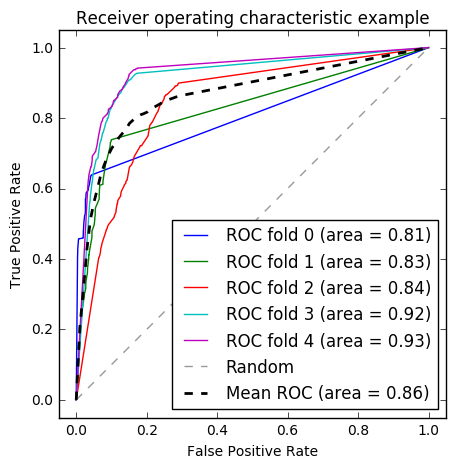

In [114]:
def plot_ROC_curve(classifier, X, y, pos_label=1, n_splits=5):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    skf = StratifiedKFold(n_splits=5)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)): #StratifiedKFold(n_splits=2, random_state=None, shuffle=False)

        probas_ = classifier.fit(X[train_index], y[train_index]).predict_proba(X[test_index])
        
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test_index], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

plot_ROC_curve(DecisionTreeClassifier(min_samples_leaf=10), Xcovtype, y_567)

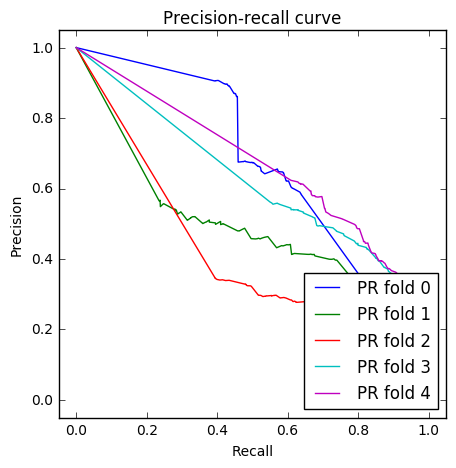

In [115]:
def plot_PR_curve(classifier, X, y, n_splits=5):
    """
    Plot a basic precision/recall curve.
    """
    for i, (train, test) in enumerate(StratifiedKFold(n_splits=5).split(X, y)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1],
                                                               pos_label=1)
        plt.plot(recall, precision, lw=1, label='PR fold %d' % (i,))
   #  clf_name = str(type(classifier))
   # clf_name = clf_name[clf_name.rindex('.')+1:]
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()

plot_PR_curve(DecisionTreeClassifier(min_samples_leaf=10), Xcovtype, y_567)

Now start doing comparisons of some classifiers on these imbalanced domains.  Right now it's:

    0:  533642  =   91.8%
    1:   47370  =    8.2%'

# First test: approximately 92 to 8

## Decision Tree classifier

First let's try a simple decision tree classifier.  **Note:** When using scikit-learn's DecisionTreeClassifier, **always** set `min_samples_leaf` to something like 5 or 10.  Its default value of 1 is useless and is guaranteed to overfit.  (This is why every example of DecisionTreeClassifier in their docs shows overfitting.)

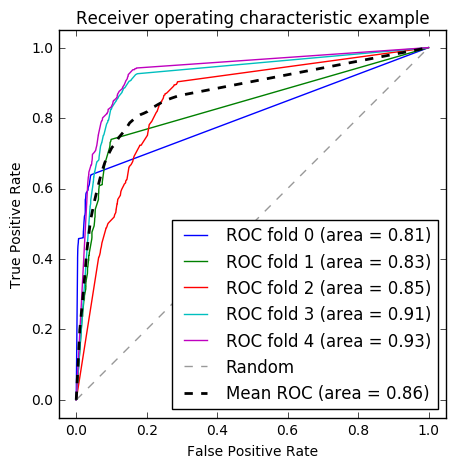

In [116]:
plot_ROC_curve(DecisionTreeClassifier(min_samples_leaf=10), Xcovtype, y_567)

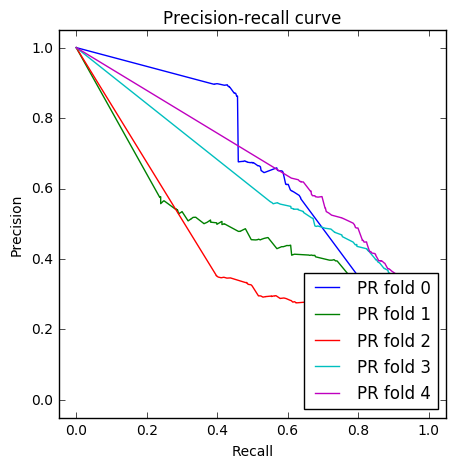

In [133]:
plot_PR_curve(DecisionTreeClassifier(min_samples_leaf=10), Xcovtype, y_567)

## Logistic Regression

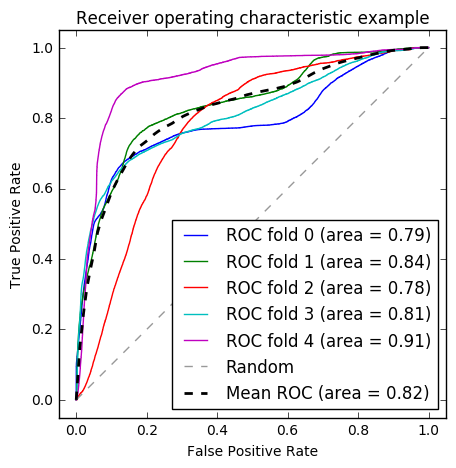

In [117]:
plot_ROC_curve(LogisticRegression(), Xcovtype, y_567)

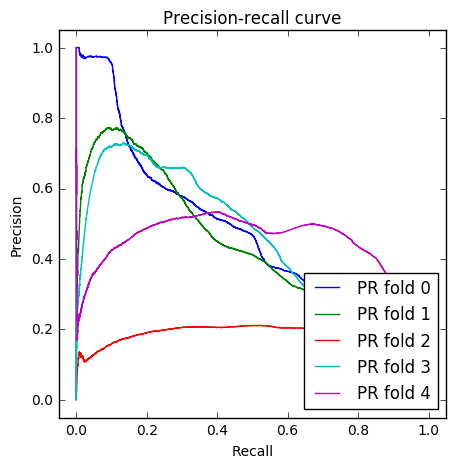

In [134]:
plot_PR_curve(LogisticRegression(), Xcovtype, y_567)

This performance is acceptable except for the odd concavities on the right-hand side.  Worse on average than decision trees, though.

## Random Forest

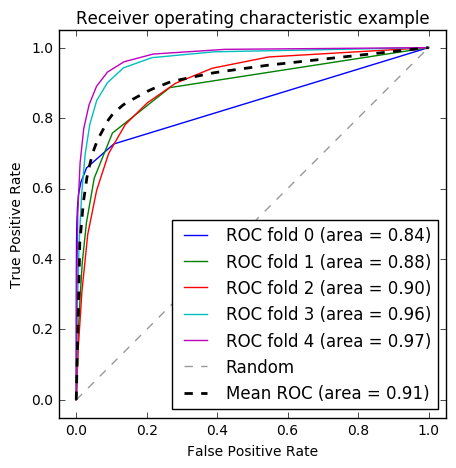

In [118]:
plot_ROC_curve(RandomForestClassifier(), Xcovtype, y_567)

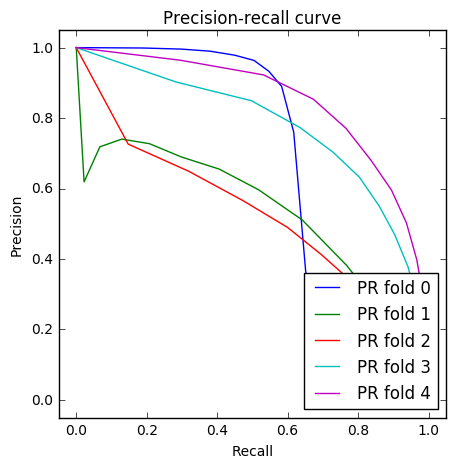

In [135]:
plot_PR_curve(RandomForestClassifier(), Xcovtype, y_567)

Random Forest Classifiers typically work very well with little tuning.  This is the best so far.

## Our Blagging classifier

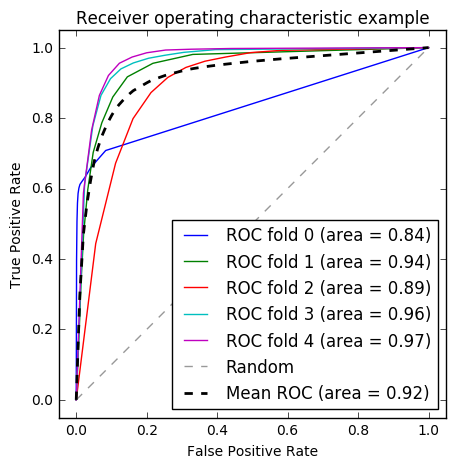

In [119]:
plot_ROC_curve(BlaggingClassifier(), Xcovtype, y_567)

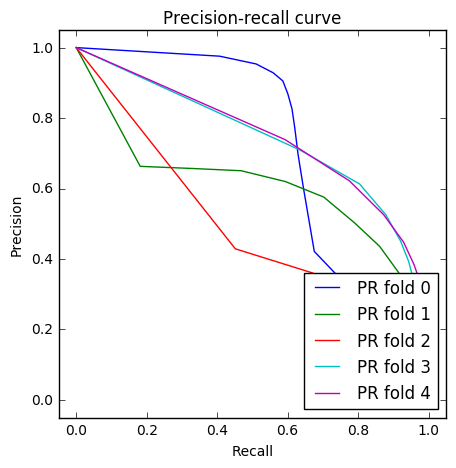

In [136]:
plot_PR_curve(BlaggingClassifier(), Xcovtype, y_567)

The blagging classifier performs best of all, with an average ROC of 0.92.

# Second test: more skewed: 97 to 3

Look at the raw example class counts again

In [132]:
class_info(covtype.target.data)

     :  211840  =    9.1%
      :  1743036  =   75.0%
     :   35754  =    1.5%
     :  283301  =   12.2%
     :    9493  =    0.4%
     :    2747  =    0.1%
     :   20510  =    0.9%
     :   17367  =    0.7%


Now we create a new, still more skewed dataset called y_6 (class 6 against all others) which is skewed 97 negatives to 3 positives.

In [121]:
y_6 = make_binary(covtype.target, {6,})

class_info(y_6)

     0:  563645  =   97.0%
     1:   17367  =    3.0%


Let's go through the same classifiers as above with this new, more skewed domain.

## Decision Tree

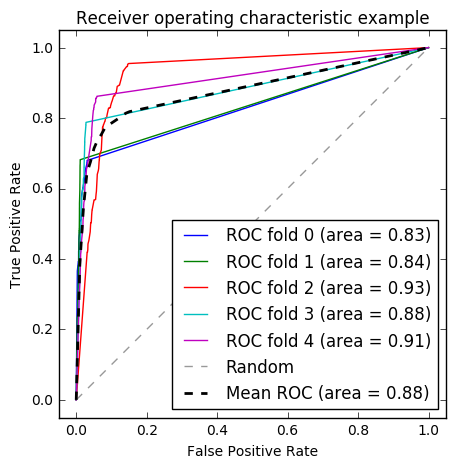

In [122]:
plot_ROC_curve(DecisionTreeClassifier(min_samples_leaf=10), Xcovtype, y_6)

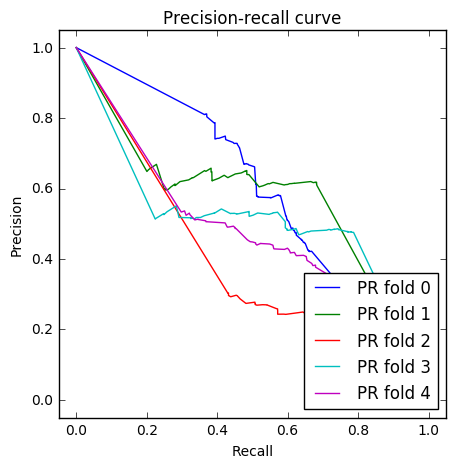

In [137]:
plot_PR_curve(DecisionTreeClassifier(min_samples_leaf=10), Xcovtype, y_6)

## Random Forest

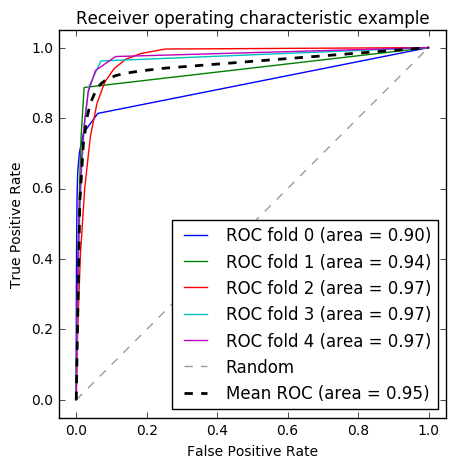

In [123]:
plot_ROC_curve(RandomForestClassifier(), Xcovtype, y_6)

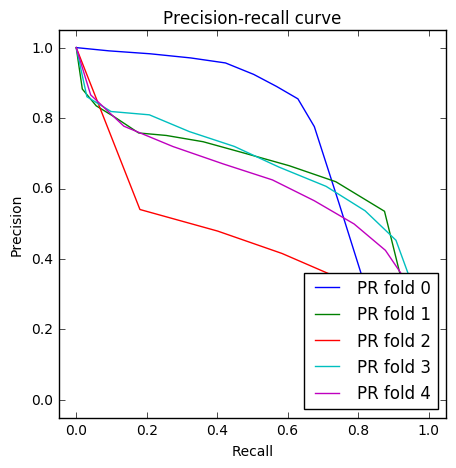

In [138]:
plot_PR_curve(RandomForestClassifier(), Xcovtype, y_6)

## Blagging classifier

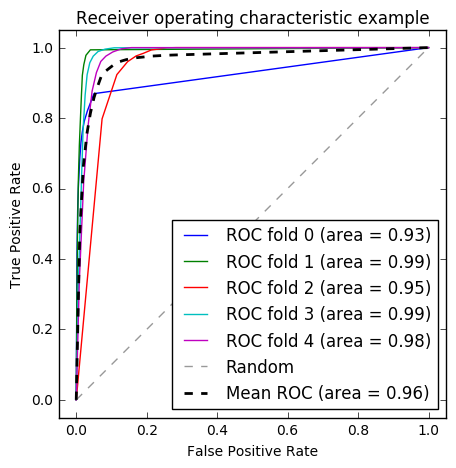

In [124]:
plot_ROC_curve(BlaggingClassifier(), Xcovtype, y_6)

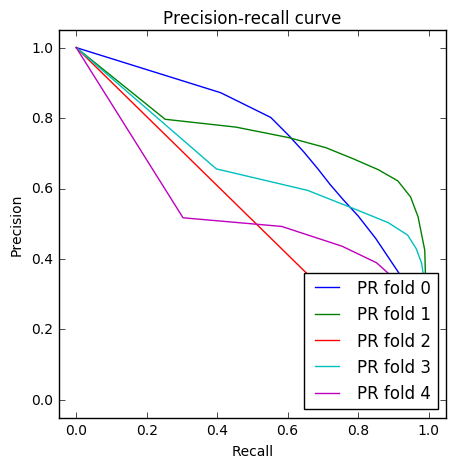

In [139]:
plot_PR_curve(BlaggingClassifier(), Xcovtype, y_6)

## Logistic Regression

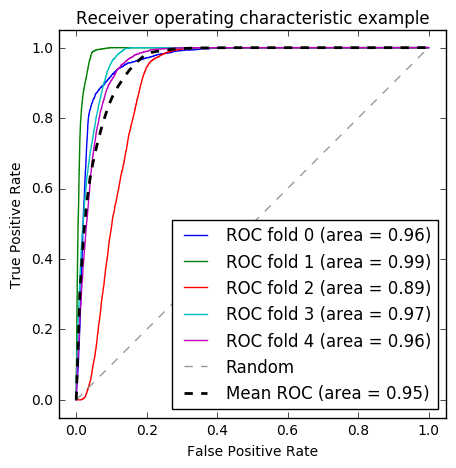

In [125]:
plot_ROC_curve(LogisticRegression(), Xcovtype, y_6)

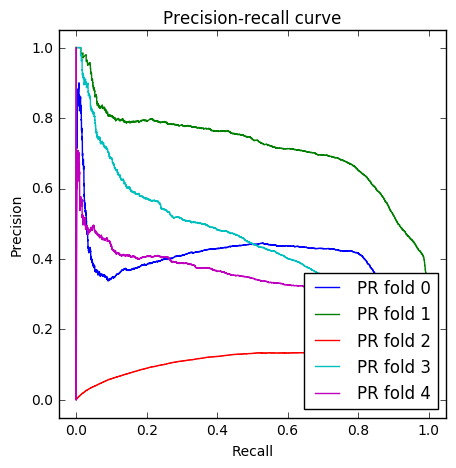

In [140]:
plot_PR_curve(LogisticRegression(), Xcovtype, y_6)

Conclusion: All the classifiers perform reasonably well.  Once again, the blagging classifier is best.

# Third test: 99.5 to 0.5

In [126]:
class_info(covtype.target)

     1:  211840  =   36.5%
     2:  283301  =   48.8%
     3:   35754  =    6.2%
     4:    2747  =    0.5%
     5:    9493  =    1.6%
     6:   17367  =    3.0%
     7:   20510  =    3.5%


In [127]:
y_4 = make_binary(covtype.target, {4,})

class_info(y_4)

     0:  578265  =   99.5%
     1:    2747  =    0.5%


## Decision tree

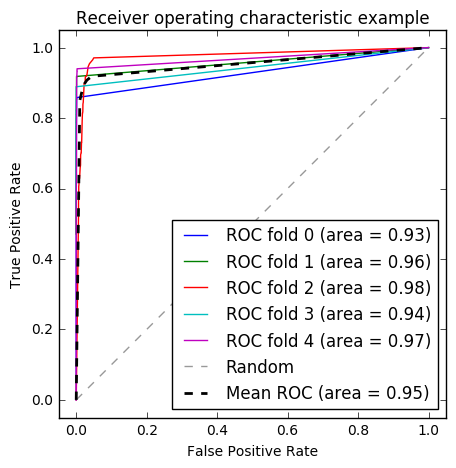

In [128]:
plot_ROC_curve(DecisionTreeClassifier(min_samples_leaf=10), Xcovtype, y_4)

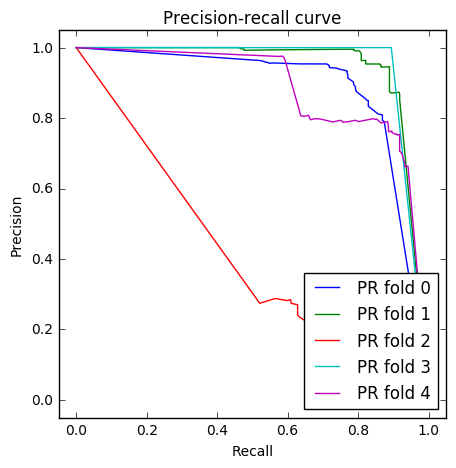

In [141]:
plot_PR_curve(DecisionTreeClassifier(min_samples_leaf=10), Xcovtype, y_4)

## Random Forest

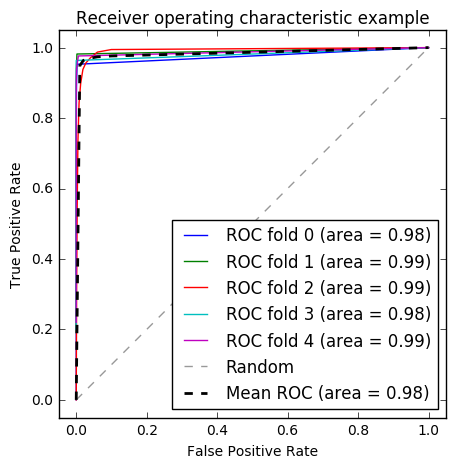

In [129]:
plot_ROC_curve(RandomForestClassifier(), Xcovtype, y_4)

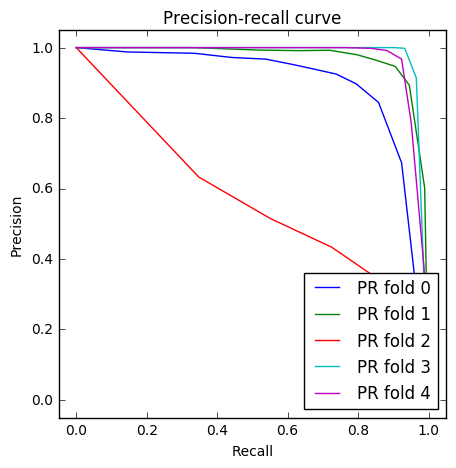

In [142]:
plot_PR_curve(RandomForestClassifier(), Xcovtype, y_4)

## Logistic regression

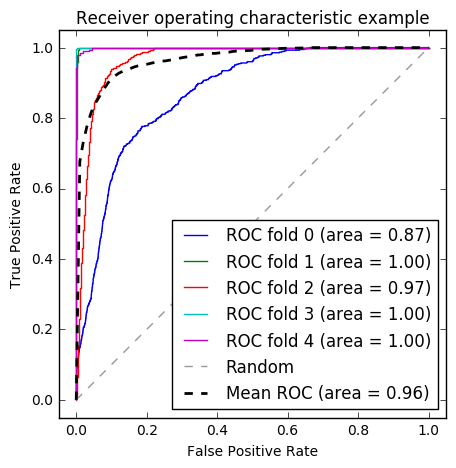

In [130]:
plot_ROC_curve(LogisticRegression(), Xcovtype, y_4)

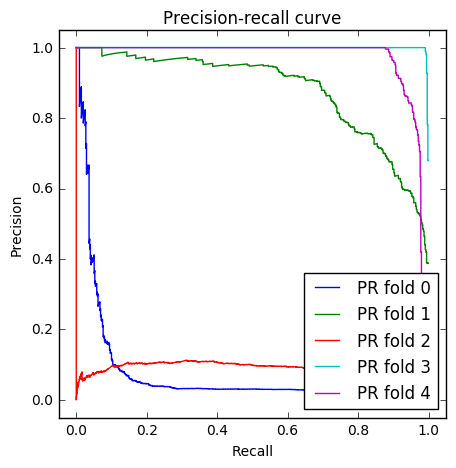

In [143]:
plot_PR_curve(LogisticRegression(), Xcovtype, y_4)

## Blagging classifier

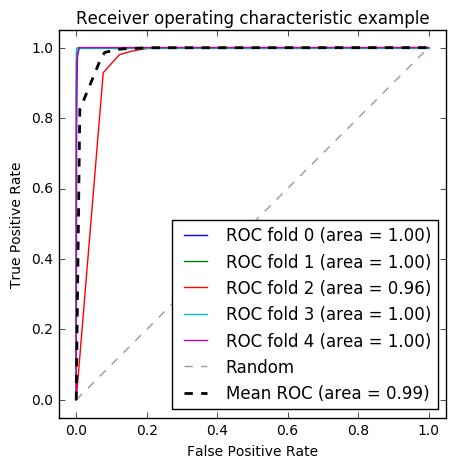

In [131]:
plot_ROC_curve(BlaggingClassifier(), Xcovtype, y_4)

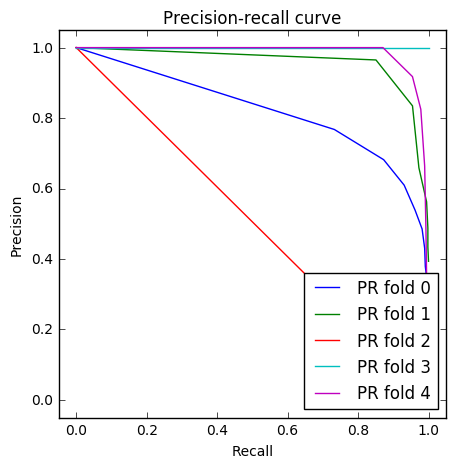

In [144]:
plot_PR_curve(BlaggingClassifier(), Xcovtype, y_4)

Once again, the blagging classifier turns in the best performance.

## A few caveats:  

- This is obviously only a *single* domain; more extensive tests would have to be done to begin to make 
an empirical case in a research paper.

- The skewed binary classes were created by arbitrarily combining certain of the original classes to get
the proportion we want.  We made no attempt to check characteristics of the classes we merged.  We probably should have consulted the 7x7 confusion matrix, to determine why the problem actually got *easier* as the skew increased.


# End

<center><h2>© <a href="http://www.svds.com">2016 Silicon Valley Data Science LLC</a></h2></center>